In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import time

In [2]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [3]:
X = sigmax()
Z = sigmaz()
Y = sigmay()
I = qeye(2)

S_X = tensor(X, X, X, X)
S_Z = tensor(Z, Z, Z, Z)

X_L_1 = tensor(X, I, X, I)
Z_L_1 = tensor(Z, Z, I, I)

X_L_2 = tensor(X, X, I, I)
Z_L_2 = tensor(Z, I, Z, I)


# Logical states
logical_zero = (tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0)) +
                tensor(basis(2, 1), basis(2, 1), basis(2, 1), basis(2, 1))).unit()
logical_one = X_L_1 * logical_zero

In [4]:
T_max = 10
times = np.linspace(0, T_max, 50)
sigma = 1
omega_max = 50
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
delta_t = lambda t: 2*omega_max*(t / (T_max/2) - 1)


In [5]:
def H(t):
    """
    Rapid Adiabatic Hamiltonian
    """
    return  X_L_1 * omega_t(t) + Z_L_1 * delta_t(t)

def H_error_gaussian(t, error_time, strength):
    """
    Error Hamiltonian localized at a specific time (e.g., bit-flip on the first qubit).
    """
    error_width = 0.5
    f_t = strength * np.exp(-((t - error_time) ** 2) / (2 * error_width ** 2))
    return f_t * tensor(X, I, I, I)

def H_error(t, error_time, strength, duration=2):
    if error_time <= t < error_time + duration:
        # ramp_strength = strength * (t - error_time) / duration
        bit_flip_1 = tensor(X, I, I, I)
        bit_flip_2 = tensor(I, X, I, I)
        bit_flip_3 = tensor(I, I, X, I) 
        bit_flip_4 = tensor(I, I, I, X)
        return strength * bit_flip_1
    else:
        # Identity when error is not active
        return tensor(I, I, I, I)

def H_supp(x, z, nu1, nu2, lambda1, lambda2, opt):
    X_A = tensor(X, X, I, I)
    Z_A = tensor(Z, I, Z, I)
    H_supp_stab = S_X + S_Z
    H_supp_gauge = -(lambda1 + lambda2*x) * X_A -(nu1 + nu2*z) * Z_A
    if opt == 'stab':
        return H_supp_stab
    elif opt == 'gauge':
        return H_supp_gauge
    else:
        raise ValueError
    
def H_total(t, error_time, error_strength, duration, x, z, nu1, nu2, lambda1, lambda2, opt, Ep):
    """
    Total Hamiltonian including AQC evolution and error simulation.
    """
    H_n = H(t) + Ep * H_supp(x, z, nu1, nu2, lambda1, lambda2, opt) + H_error(t, error_time, error_strength, duration)
    return H_n


In [6]:
lambda1 = -1
lambda2 = -1
nu1 = -1
nu2 = -1
x = -1
z = 1
Ep = -200
error_time = 6
duration = T_max - error_time
error_strength = 50
opt = 'gauge'

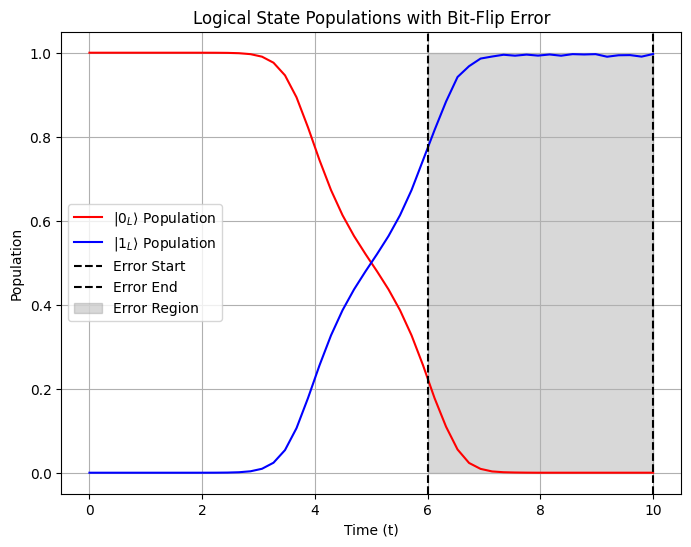

In [7]:
# Simulate evolution
e_ops = [logical_zero*logical_zero.dag(), logical_one*logical_one.dag()]

result = sesolve(lambda t: H_total(t, error_time, error_strength, duration, x, z, nu1, nu2, lambda1, lambda2, opt, Ep),
                 logical_zero, times, e_ops=e_ops, 
                 options={'nsteps': 1e5})

plt.figure(figsize=(8, 6))
plt.plot(times, result.expect[0], label=r"$|0_L\rangle$ Population", color='red')
plt.plot(times, result.expect[1], label=r"$|1_L\rangle$ Population", color='blue')
# Add vertical lines for the start and end of the error
plt.axvline(error_time, color='black', linestyle='--', label="Error Start")
plt.axvline(error_time + duration, color='black', linestyle='--', label="Error End")

# Shade the area between the lines
plt.fill_betweenx(
    [0, 1],  # Adjust y-limits based on your data range
    error_time,
    error_time + duration,
    color='gray',
    alpha=0.3,
    label="Error Region"
)

plt.xlabel("Time (t)")
plt.ylabel("Population")
plt.title("Logical State Populations with Bit-Flip Error")
plt.legend()
plt.grid()
plt.show()

In [1]:
def bose_einstein_distribution(energy_diff, temperature):
    if temperature == 0:
        return 0
    return 1 / (np.exp(energy_diff / (temperature)) - 1)

def gab(omega1, omega2, lambda_2):
    if omega1 >= omega2:
        return 0
    return np.sqrt(lambda_2)
    
def c_ops_gen(t, args):
    """
    Robustness of adiabatic quantum computation - from this paper
    :param t: time parameter 
    :param args: dictionary of optional arguments
    :return: a matrix of the collapse operator
    """
    H_inst_t = args['args_H'](t)  # Instantaneous Hamiltonian at time t
    eigenvalues, eigenstates = H_inst_t.eigenstates()
    
    sigmam_i = args['sigma_i']
    
    # Initialize a single collapse operator for this qubit
    collapse_op = Qobj(np.zeros_like(sigmam_i.full()), dims=sigmam_i.dims)
    
    for omega_a, a in zip(eigenvalues, eigenstates):
        for omega_b, b in zip(eigenvalues, eigenstates):
            if np.abs(omega_a - omega_b) < 1e-6:
                continue  # Skip nearly degenerate states
            
            # For decay transitions (omega_b > omega_a)
            if omega_b > omega_a:
                Nba = bose_einstein_distribution(omega_b - omega_a, args['T'])
                g_ba = gab(omega_a, omega_b, args['lambda_2'])
                
                ma_ba = a.dag() * sigmam_i * b * b.dag() * sigmam_i.dag() * a
                
                decay_op = np.sqrt(Nba * (g_ba ** 2) * ma_ba) * (b * a.dag())
                collapse_op += decay_op

            # For excitation transitions (omega_a > omega_b)
            elif omega_a > omega_b:
                Nab = bose_einstein_distribution(omega_a - omega_b, args['T'])
                g_ab = gab(omega_b, omega_a, args['lambda_2'])
                
                ma_ab = b.dag() * sigmam_i * a * a.dag() * sigmam_i.dag() * b
                
                excitation_op = np.sqrt((Nab + 1) * (g_ab ** 2) * ma_ab) * (b * a.dag())

                collapse_op += excitation_op
    # print(collapse_op)
    return collapse_op

In [ ]:
# Time-dependent Hamiltonian
def H_t(t):
    return H(t) + Ep * H_supp(x, z, nu1, nu2, lambda1, lambda2, opt)  # Assuming H_x and H_z are valid Qobjs

n_qubits = 4
gamma_sqrt= 0.9
T = 100

args_C = {"H": H_t,
          "n_qubits": n_qubits,
          "lambda_2": gamma_sqrt,
          "T": T}

c_ops_s = []
for i in range(n_qubits):
    args_C = {"args_H": H_t,
              "n_qubits": n_qubits,
              "lambda_2":gamma_sqrt,
              "T":T,
              "sigma_i": Qobj(tensor([sigmam() if j == i else I for j in range(n_qubits)]).data, dims=H_t(0).dims)
             }
    c_ops_i = QobjEvo(c_ops_gen, args=args_C)
    c_ops_s.append(c_ops_i)
    # c_ops_s.append(lambda t: c_ops_gen(t, args_C))

rho0 = logical_zero*logical_zero.dag()
# Solve the master equation
results = mesolve(H_t, rho0, times, c_ops=c_ops_s, e_ops=e_ops,
                  options={'nsteps': 1e4})

# Plotting results
plt.plot(times, results.expect[0], label=r"$\rho_0$")
plt.plot(times, results.expect[1], label=r"$\rho_1$")

plt.grid()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population Evolution ' + 
          r"$\langle\varphi|\rho_{0/1}(t)|\varphi\rangle$" + 
          ' of Each Logical Qubits Over Time with Dissipation' + 
          f" - Temp = {T} - " + 
          f"gamma = {gamma_sqrt}")
plt.show()

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/Users/chenscheim/PycharmProjects/QEC_A/myenv/lib/python3.12/site-packages/qutip/solver/integrator/scipy_integrator.py", line 69, in _mul_np_vec
    out = self.system.matmul_data(t, state)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "qutip/core/cy/qobjevo.pyx", line 1105, in qutip.core.cy.qobjevo.QobjEvo.matmul_data
  File "qutip/core/cy/qobjevo.pyx", line 1117, in qutip.core.cy.qobjevo.QobjEvo.matmul_data
  File "qutip/core/cy/_element.pyx", line 619, in qutip.core.cy._element._ProdElement.matmul_data_t
  File "qutip/core/cy/_element.pyx", line 165, in qutip.core.cy._element._BaseElement.matmul_data_t
  File "qutip/core/cy/_element.pyx", line 546, in qutip.core.cy._element._MapElement.data
  File "qutip/core/cy/_element.pyx", lin

In [ ]:
# Time-dependent Hamiltonian
def H_t(t):
    return H(t) + Ep * H_supp(x, z, nu1, nu2, lambda1, lambda2, opt)  # Assuming H_x and H_z are valid Qobjs

n_qubits = 4
gamma_sqrt= 0.9
T = 100

args_C = {"H": H_t,
          "n_qubits": n_qubits,
          "lambda_2": gamma_sqrt,
          "T": T}

c_ops_s = []
for i in range(n_qubits):
    args_C = {"args_H": H_t,
              "n_qubits": n_qubits,
              "lambda_2":gamma_sqrt,
              "T":T,
              "sigma_i": Qobj(tensor([sigmam() if j == i else I for j in range(n_qubits)]).data, dims=H_t(0).dims)
             }
    c_ops_i = QobjEvo(c_ops_gen, args=args_C)
    c_ops_s.append(c_ops_i)
    # c_ops_s.append(lambda t: c_ops_gen(t, args_C))
    # 

print("C Ops Generation Completed")

rho0 = logical_zero
# Solve the master equation
results = mcsolve(H_t, rho0, times, c_ops=c_ops_s, e_ops=e_ops,
                  options={'nsteps': 1e4})

# Plotting results
plt.plot(times, results.expect[0], label=r"$\rho_0$")
plt.plot(times, results.expect[1], label=r"$\rho_1$")

plt.grid()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population Evolution ' + 
          r"$\langle\varphi|\rho_{0/1}(t)|\varphi\rangle$" + 
          ' of Each Logical Qubits Over Time with Dissipation' + 
          f" - Temp = {T} - " + 
          f"gamma = {gamma_sqrt}")
plt.show()